In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

In [25]:
res_LUKE = (0.65, 0.65, 1)
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210412_crude_rois_in_luke.nii'
mimic_moco = np.asarray(nib.load(load_file).get_data().squeeze(), dtype='float32')

# Want 512,1024,256
anat = np.swapaxes(mimic_moco,0,1)
print(anat.shape)

anat_iso = ants.resample_image(ants.from_numpy(anat),(int(512*0.65), int(1024*0.65), int(256*1)),1,0).numpy()

(512, 1024, 256)


In [63]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

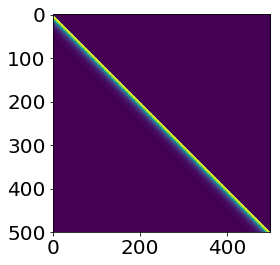

In [64]:
############################
### Load super voxel ids ###
############################

n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 50, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 450), 'constant')

toe = scipy.linalg.toeplitz(filter_padded,r=[0]*500)
plt.imshow(toe)

In [66]:
for fly in fly_names:
    print(fly)
    ####################
    ### Load filters ###
    ####################
    main_path = F"/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210210_neural_weighted_behavior_singles/{fly}"

    response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
    bbb.sort_nicely(response_files)

    responses = []
    for file in response_files:
        responses.append(np.load(file))
    responses = np.asarray(responses)
    responses_split = np.reshape(responses, (49,2000,3,500))

    ##########################
    ### Apply notch filter ###
    ##########################
    responses_notch = signal.filtfilt(b_notch, a_notch, responses_split, axis=-1)

    ########################
    ### Deconvolve gcamp ###
    ########################

    all_signals_unfiltered = np.reshape(responses_split[:,:,:,:],(49*2000,3,500))
    all_signals = np.reshape(responses_notch,(49*2000,3,500))

    all_signals_flipped = all_signals[:,:,::-1]
    all_signals_deconv = []
    for beh_idx in [0,1,2]:
        print(beh_idx)
        # flip filters in time
        temp = all_signals_flipped[:,beh_idx,:]

        # deconvolve
        deconv = np.linalg.lstsq(toe, temp.T)[0]
        deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

        # Remove edge artifact
        deconv_smooth[:5,:] = deconv_smooth[5,:]
        deconv_smooth[-5:,:] = deconv_smooth[-5,:]

        # Flip back to being backwards in time
        deconv_smooth = deconv_smooth[::-1,:]
        all_signals_deconv.append(deconv_smooth)
    all_signals_deconv = np.asarray(all_signals_deconv)
    all_signals_deconv = np.swapaxes(all_signals_deconv,0,1)
    all_signals_deconv = np.swapaxes(all_signals_deconv,0,2)

    ######################
    ### Get peaks, etc ###
    ######################

    all_maxs = np.max(np.abs(all_signals_deconv),axis=-1)
    thresholds = np.percentile(all_maxs,60,axis=0)

    peaks = {}
    peaks_ms = {}
    peaks_unfiltered = {}
    thresholded_filters_norm = {}
    thresholded_filters_norm_unfiltered = {}
    to_delete = {}
    decay_times = {}
    maxss = {}
    for beh_idx in [0,1,2]:
        print(beh_idx)
        to_delete_ = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
        thresholded_filters = np.delete(all_signals_deconv[:,beh_idx,:], to_delete_, axis=0)

        # add gaussian smoothing
        thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)

        peaks_ = np.argmax(thresholded_filters,axis=-1)
        #idx_sort = np.argsort(peaks)
        maxs = np.max(thresholded_filters,axis=-1)
        maxss[beh_idx] = maxs

        thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]

        peaks[beh_idx] = peaks_
        peaks_ms[beh_idx] = (peaks_-250)*20
        thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
        to_delete[beh_idx] = to_delete_

        thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], to_delete_, axis=0)
        maxs = np.max(thresholded_filters_unfiltered,axis=-1)
        thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
        thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_

        peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
        peaks_unfiltered[beh_idx] = peaks_

        # add tau finding
        decay_times_ = []
        decay_amount = .5
        for i in range(len(peaks[beh_idx])):
            trace = thresholded_filters_norm[beh_idx][i,:]
            try:
                decay_time = np.where((np.where(trace<decay_amount)[0] < peaks[beh_idx][i]) == False)[0][0]-1
            except:
                decay_time = 0
            decay_times_.append(decay_time)
        decay_times[beh_idx] = decay_times_

    ### Save output ###
    to_save = ['thresholded_filters_norm', 'maxss', 'decay_times', 'peaks', 'to_delete']
    for data in to_save:
        save_path = os.path.join(main_path, data + '.pickle')
        with open(save_path, 'wb') as handle:
            pickle.dump(eval(data), handle, protocol=pickle.HIGHEST_PROTOCOL)

fly_087
0
1
2
0
1
2
fly_089
0
1
2
0
1
2
fly_094
0
1
2
0
1
2
fly_097
0
1
2
0
1
2
fly_098
0
1
2
0
1
2
fly_099
0
1
2
0
1
2
fly_100
0
1
2
0
1
2
fly_101
0
1
2
0
1
2
fly_105
0
1
2
0
1
2


In [37]:
for beh_idx in [0]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(98000)
    to_replace = [i for i in range(98000) if i not in to_delete[beh_idx][0]]
    #add_deleted_voxels[to_replace] = peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    #add_deleted_voxels[to_replace] = peaks[beh_idx] - decay_times[beh_idx]
    add_deleted_voxels[to_replace] = maxss[beh_idx]
    to_plot = np.reshape(add_deleted_voxels, (49,2000))

    all_colored_by_betas = []
    for z in range(49):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    #all_colored_by_betas[all_colored_by_betas==0] = np.nan

In [38]:
# want 128,256,49
func = np.swapaxes(all_colored_by_betas,0,2)
print(func.shape)

func_iso = ants.resample_image(ants.from_numpy(func),(int(512*0.65), int(1024*0.65), int(256*1)),1,1,).numpy()

(128, 256, 49)


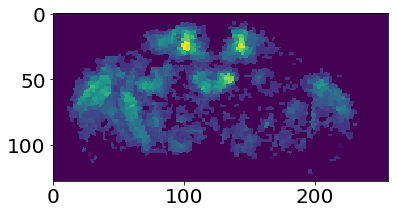

In [39]:
plt.imshow(func[:,:,20])

In [40]:
FB = 26
rois = {'FB': 26, 'Medulla': 71, 'Lobula': 53, 'SLP_r': 27}
roi = 'FB'
anat_iso_mask = anat_iso.copy()
anat_iso_mask[np.where(anat_iso_mask != rois[roi])]=0
anat_iso_mask[np.where(anat_iso_mask != 0)]=1

In [41]:
masked_XY = np.max(func_iso*anat_iso_mask,axis=2)
masked_XY[np.where(masked_XY==0)] = np.nan
print(masked_XY.shape)

masked_XZ = np.max(func_iso*anat_iso_mask,axis=0)
masked_XZ[np.where(masked_XZ==0)] = np.nan
print(masked_XZ.shape)

masked_YZ = np.max(func_iso*anat_iso_mask,axis=1)
masked_YZ[np.where(masked_YZ==0)] = np.nan
print(masked_YZ.shape)

(332, 665)
(665, 256)
(332, 256)


In [42]:
start = 265
end = 235
middle = 250

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

mymap.set_bad(color='grey')

In [43]:
left_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=0)>0)[0][0]
right_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=0)>0)[0][-1]

top_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=1)>0)[0][0]
bottom_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=1)>0)[0][-1]

deep_edge = np.where(np.sum(np.nan_to_num(masked_XZ),axis=0)>0)[0][0]
shallow_edge = np.where(np.sum(np.nan_to_num(masked_XZ),axis=0)>0)[0][-1]

In [44]:
dim_x = right_edge-left_edge
dim_y = bottom_edge-top_edge
dim_z = shallow_edge-deep_edge

dim_x = dim_x / 100
dim_y = dim_y / 100
dim_z = dim_z / 100
print(dim_x, dim_y, dim_z)

1.04 0.86 0.75


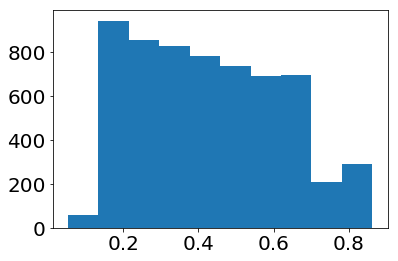

In [45]:
plt.hist(masked_XY.flatten());

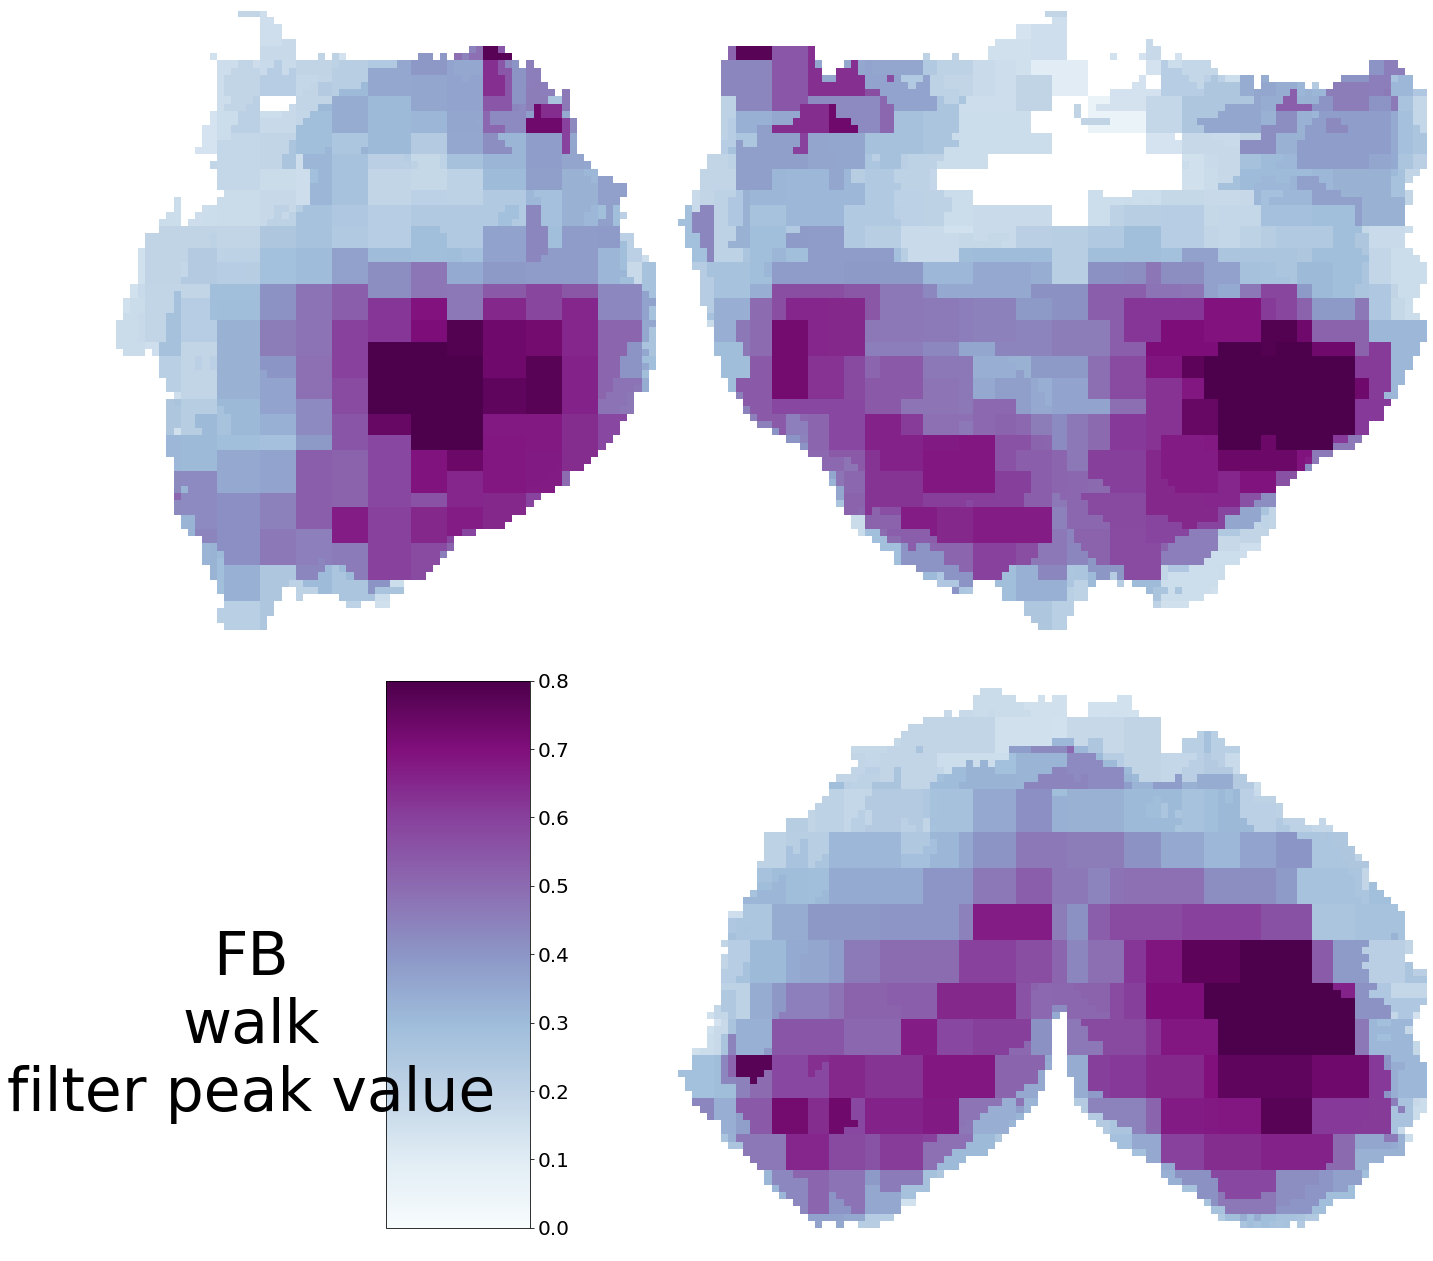

In [47]:
fig = plt.figure(figsize=(10,10))
space = .03
vmax = .8

ax = fig.add_axes([dim_z+space,0,dim_x,dim_y])
colorbar_c = ax.imshow(masked_XY[top_edge:bottom_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=vmax);
ax.axis('off')

ax = fig.add_axes([0,0,dim_z,dim_y])
ax.imshow(masked_YZ[top_edge:bottom_edge, deep_edge:shallow_edge],cmap='BuPu',vmin=0,vmax=vmax);
ax.axis('off')

ax = fig.add_axes([dim_z+space,-dim_y+space,dim_x,dim_z])
ax.imshow(masked_XZ.T[deep_edge:shallow_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=vmax);
ax.axis('off')

plt.suptitle('FB\nwalk\nfilter peak value',fontsize=60,x=dim_z/4,y=(-dim_y+space)/2)

# Color Bar
axColor = plt.axes([dim_z/2,-dim_y+space,.2,dim_y-.1])
cbar = plt.colorbar(colorbar_c, cax = axColor)#, ticks=[start, middle, vmax])
#cbar.ax.set_yticklabels(['300ms\n(Pre)', '0', '300ms\n(Post)'], fontsize=20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')